In [1]:
import ee
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()
    
import datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.ticker
import cartopy
import cartopy.crs as ccrs                   # for projections
import cartopy.feature as cfeature           # for features
import cartopy.io.shapereader as shapereader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature.nightshade import Nightshade

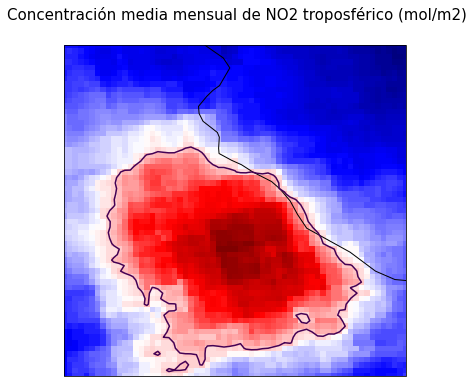

In [3]:
delta= 0
lat_n=-34.32
lat_s=-34.93
lon_w=-58.76
lon_e=-58.13 
roi = ee.Geometry.Rectangle([np.round(lon_w-delta,2), np.round(lat_s-delta,2), np.round(lon_e+delta,2), np.round(lat_n+delta,2)],geodesic= False,proj='EPSG:4326')


inicio='2019-04-01'
final ='2019-05-01' 
 

####De acá en adelante traten de no tocar nada a menos que tengan claro####

collection=ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select(
    'tropospheric_NO2_column_number_density').filterBounds(roi).filterDate(inicio,final)
collection_img=collection.mean().setDefaultProjection(collection.first().projection())
latlon=ee.Image.pixelLonLat().addBands(collection_img)
latlon_new = latlon.reduceRegion(reducer=ee.Reducer.toList(), geometry=roi, maxPixels=1e13,scale=1113.2)

no2 = np.array((ee.Array(latlon_new.get('tropospheric_NO2_column_number_density')).getInfo()))
lats = np.array((ee.Array(latlon_new.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon_new.get("longitude")).getInfo()))  ##Prueben hacer lons.shape y y van a ver que es un horror.

uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)
ncols = len(uniqueLons)    
nrows = len(uniqueLats)


no2_2019=no2.reshape(nrows,ncols)
LATS=lats.reshape(nrows,ncols)
LONS=lons.reshape(nrows,ncols)


## rutina de graficado

cmap=mpl.cm.get_cmap('seismic',100)  
fig, axs = plt.subplots(nrows=1,ncols=1, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,6))
fig.subplots_adjust(top=0.89,right=0.87,wspace=0.05, hspace=0.07)
plt.suptitle('Concentración media mensual de NO2 troposférico (mol/m2)',fontsize=15)#,y=0.93)
cs=axs.pcolormesh(LONS,LATS,no2_2019,vmin=0,vmax=np.max(no2_2019), cmap=cmap)
CS= axs.contour(LONS,LATS,no2_2019,levels=[np.quantile(no2_2019,0.7)])
axs.add_feature(cartopy.feature.COASTLINE)
axs.add_feature(cartopy.feature.BORDERS)
#axs[0].add_geometries(data.geometries(), crs=ccrs.Geodetic(), edgecolor='k', facecolor='none')
axs.set_extent([np.min(LONS), np.max(LONS), np.min(LATS), np.max(LATS)])

Este es el core de funciones de la mascara

In [4]:
def max_curve(x):
    return max(x, key=len)

def mask_curve(lon,lat,array,q):  ###dadp un array, una retícula y un percentil devuelve una lista de puntos de latitud longitud
    import matplotlib.pyplot as plt
    import numpy as np
    CS=plt.contour(lon,lat,array,levels=[np.quantile(array,q)])
    points=max_curve(CS.allsegs[0])
    ##creo un csv para guardar las coordenadas de la mascara ##
    points_dic={'Lon':points[:,0],'Lat':points[:,1]}
    points_df=pd.DataFrame(data=points_dic)
    points_df.to_csv('coordMask.csv',index=False)
    list_points=points.tolist()
    plt.close()
    if list_points[0]!=list_points[-1]:
        list_points=list_points + [list_points[0]]
    return list_points

def mask_percentil(array,q): ###dado un array devuelve una matriz de 1 y 0 con 1 los puntos donde se supere el percentil q
    import numpy.ma as ma
    import numpy as np
    perNO2=np.quantile(array,q)
    mask=ma.masked_less_equal(array,perNO2)
    ones_arr= np.ones(array.shape)
    ones_arr= ma.array(ones_arr, mask=mask.mask)
    ones_arr= ma.MaskedArray(ones_arr,fill_value=0).filled().astype(int)
    #pix=len(array[array>perNO2])
    return ones_arr

def mask_onescurve(lon,lat,array,q):  ##igual que mask_curve pero sobre la matrices de 1 y 0. No cambia mucho hay que estimar el error  
    import matplotlib.pyplot as plt
    ones_arr=mask_percentil(array,q)
    CS=plt.contour(lon,lat,ones_arr,levels=[0.5])
    points=max_curve(CS.allsegs[0])
    points_dic={'Lon':points[:,0],'Lat':points[:,1]}
    points_df=pd.DataFrame(data=points_dic)
    points_df.to_csv('coordMaskOnes.csv',index=False)
    list_points=points.tolist()
    plt.close()
    if list_points[0]!=list_points[-1]:
        list_points=list_points + [list_points[0]]
    return list_points  ##asi como sale puede entrarr a roi=ee.Geometry.Polygon(list_points)

def pixel_in_contour(lon,lat,curve):  ##cuenta la cantidad de pixeles dentro de la mascara
    import math
    import matplotlib.path
    import numpy as np
    points = np.hstack((lon.reshape((-1,1)), lat.reshape((-1,1))))
    path = matplotlib.path.Path(curve)
    mask = path.contains_points(points)
    return np.sum(mask)

Acá llamo a las funciones y las evalúo

In [7]:
mask=mask_percentil(no2_2019,0.7)  #array de 0 y 1 
mask_list=mask_curve(LONS,LATS,no2_2019,0.7)  ## curva calculada con la matriz original
maskones_list=mask_onescurve(LONS,LATS,no2_2019,0.7) ##curva calculada con la matriz de ceros y unos ,esto es otra metodología nomás
suma=pixel_in_contour(LONS,LATS,max_curve(CS.allsegs[0]))
print('puntos dentro del contorno: ',suma)

puntos dentro del contorno:  1151


Mapa de la máscara (el array de 1 y 0)

1153

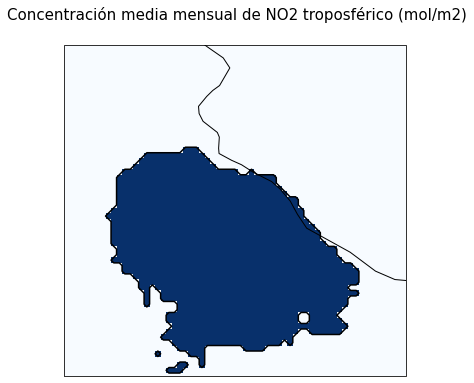

In [6]:
##grafico la mascara de 0 y 1 y hago la suma de pixeles

cmap=mpl.cm.get_cmap('Blues',100)  

fig, axs = plt.subplots(nrows=1,ncols=1, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,6))
fig.subplots_adjust(top=0.89,right=0.87,wspace=0.05, hspace=0.07)
plt.suptitle('Concentración media mensual de NO2 troposférico (mol/m2)',fontsize=15)#,y=0.93)
cs=axs.pcolormesh(LONS,LATS,mask,vmin=0,vmax=np.max(no2_2019), cmap=cmap)
CS= axs.contour(LONS,LATS,mask,levels=[0.5],colors=['black'])
#CS1= axs.contour(LONS,LATS,no2_2019,levels=[np.quantile(no2_2019,0.7)],colors=['yellow'])

axs.add_feature(cartopy.feature.COASTLINE)
axs.add_feature(cartopy.feature.BORDERS)
axs.set_extent([np.min(LONS), np.max(LONS), np.min(LATS), np.max(LATS)])
np.sum(mask)  ##cuento los pixeles azules (es ligeramente diferente a los puntos dentro de la curva grande)